In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

In [2]:
def plot_graph(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string], '')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

In [6]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
INPUT_TRAIN_DATA ='nsmc_train_input.npy'
LABEL_TRAIN_DATA ='nsmc_train_label.npy'
DATA_CONFIGS = 'nsmc_data_configs.json'

In [7]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [8]:
train_input = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA,'rb'))
train_label = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA,'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [9]:
model_name = 'cnn_classifier_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 10
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name,
         'vocab_size': prepro_configs['vocab_size'],
         'embedding_size':128,
         'num_filters': 100,
         'dropout_rate': 0.5,
         'hidden_sdimension':250,
         'output_dimension':1}

In [19]:
class CNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size']+1,
                                          output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                        kernel_size=kernel_size,padding='valid',
                                        activation='relu',
                                        kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                                        #가중치 값이 너무 커지지 않도록 제한한것
                          for kernel_size in [3, 4, 5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_sdimension'],
                                activation='relu',
                                kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                                activation='sigmoid',
                                kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    def call(self,x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [20]:
model = CNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [21]:
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print('{} -- Folder already exists \n'.format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print('{} -- Folder create complete \n'.format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(checkpoint_path, monitor ='val_accuracy', verbose=1,
                             save_best_only=True, save_weights_only=True)

./data_out/cnn_classifier_kr -- Folder already exists 



In [22]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/10
264/264 [==============================] - ETA: 0s - loss: 0.4579 - accuracy: 0.7765
Epoch 00001: val_accuracy improved from -inf to 0.81860, saving model to ./data_out/cnn_classifier_kr\weights.h5
264/264 [==============================] - 20s 76ms/step - loss: 0.4579 - accuracy: 0.7765 - val_loss: 0.3967 - val_accuracy: 0.8186
Epoch 2/10
264/264 [==============================] - ETA: 0s - loss: 0.3518 - accuracy: 0.8453
Epoch 00002: val_accuracy improved from 0.81860 to 0.82687, saving model to ./data_out/cnn_classifier_kr\weights.h5
264/264 [==============================] - 22s 83ms/step - loss: 0.3518 - accuracy: 0.8453 - val_loss: 0.3853 - val_accuracy: 0.8269
Epoch 3/10
264/264 [==============================] - ETA: 0s - loss: 0.3010 - accuracy: 0.8730
Epoch 00003: val_accuracy did not improve from 0.82687
264/264 [==============================] - 21s 81ms/step - loss: 0.3010 - accuracy: 0.8730 - val_loss: 0.3993 - val_accuracy: 0.8216
Epoch 4/10
264/264 [=========

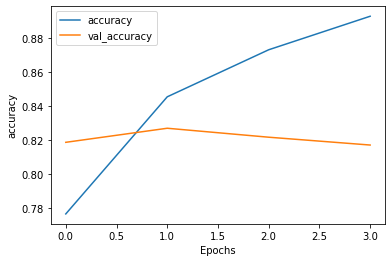

In [23]:
plot_graph(history,'accuracy')

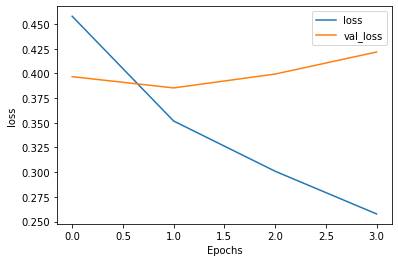

In [24]:
plot_graph(history,'loss')

In [26]:
INPUT_TEST_DATA = 'nsmc_test_input.npy'
LABEL_TEST_DATA = 'nsmc_test_label.npy'
SAVE_FILE_NM = 'weights.h5'

test_input = np.load(open(DATA_IN_PATH + INPUT_TEST_DATA, 'rb'))
test_label_data = np.load(open(DATA_IN_PATH + LABEL_TEST_DATA, 'rb'))


In [27]:
model.load_weights(os.path.join(DATA_OUT_PATH, model_name,SAVE_FILE_NM))

In [28]:
model.evaluate(test_input, test_label_data)

1563/1563 [==============================] - 1s 810us/step - loss: 0.3881 - accuracy: 0.8272


[0.38809505105018616, 0.8272200226783752]